In [1]:
import os
import sys
import pickle as pk
import numpy as np

In [2]:
os.listdir()

['metrics_helpers.py',
 'organized.ipynb',
 'debug_netmums_scrape_135results.py',
 'Untitled.ipynb',
 'term_counts.ipynb',
 '.ipynb_checkpoints']

In [3]:
if 'term_counts.ipynb' in os.listdir():
    os.chdir('../')

In [4]:
from facebook import facebook_helper as facehelp
from netmums import scrapehelpers as scr

In [5]:
[file for file in os.listdir('facebook/') if file.endswith('.pkl')]

['sp_search_results_temp.pkl',
 'fb_data_searchscrape_BACKUP.pkl',
 'ddg_search_results_temp.pkl',
 'manual_search_resdict.pkl',
 'fb_safety.pkl',
 'google_search_results.pkl',
 'specific_fb_groups.pkl',
 'fb_search_results.pkl',
 'fb_data_searchscrape.pkl',
 'few-google_search_results_temp.pkl',
 'google_search_results_temp.pkl',
 'specific_fb_pages.pkl']

In [6]:
[file for file in os.listdir('netmums/') if file.endswith('.pkl')]

['basicblurbs.pkl',
 'allposts_rerun.pkl',
 'allposts2.pkl',
 'allposts.pkl',
 'basicblurbs2.pkl']

In [7]:
#Load Datasets
with open('facebook/fb_data_searchscrape.pkl', 'rb') as f:
    fb_search = pk.load(f)
with open('facebook/specific_fb_pages.pkl', 'rb') as f:
    pages = pk.load(f)
with open('facebook/specific_fb_groups.pkl', 'rb') as f:
    groups = pk.load(f)
with open('netmums/allposts_rerun.pkl', 'rb') as f:
    netmums = pk.load(f)

In [8]:
with open('facebook/manual_search_resdict.pkl', 'rb') as f:
    fb_resultdict = pk.load(f)

In [9]:
#i made a mistake when creating the facebook data so I need to fix it.
fb_urldict = facehelp.resultsdict_to_urldict(fb_resultdict)
#we need to add the query backin for each.
for key in fb_urldict.keys():
    #both dicts should have the exact same keys
    if key in fb_search.keys() and type(fb_search[key]) is list:
        fb_search[key] = {'query':fb_urldict[key]['query'], 'data':fb_search[key]}

In [10]:
#netmums remove 404'd pages
nmkeys = list(netmums.keys())
emptykeys = []
for key in netmums.keys():
    if len(netmums[key]['posts']) == 0:
        emptykeys.append(key)
        
for key in emptykeys:   
    netmums.pop(key, None)
    
nmkeys = list(netmums.keys())

In [11]:
print(len(fb_search),
len(pages),
len(groups),
len(netmums)
     )

447 5 5 6497


In [12]:
import re
import matplotlib.pyplot as plt

In [13]:
search_posts = [key for key in fb_search.keys() if re.search('posts/[^?]+',key)]
search_pages = [key for key in fb_search.keys() if not re.search('posts/[^?]+',key)]

In [14]:
import pandas as pd

## Stats for Number of Word Occurences

we generate counts for out terms of interest per document. Where a document is considered as all the text of a given facebook post (incl comments) or netmums thread.


TODO: use stemming or some other method to capture instances of words in a cleaner way.

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

In [17]:
def get_counts_from_text_dict(text_dict):
	vocab = scr.get_concerns() + scr.get_foods()
	vocab = {substring.lower().strip() for item in vocab for substring in item.split()}
	term_counter = CountVectorizer(vocabulary = vocab, stop_words = 'english')
	return term_counter.fit_transform(text_dict.values()), term_counter

## Facebook

In [26]:
#make a dict of just the strings
#HOW:
#get a list of all posts in the value
#from that extract post_text, text, and a flattened string from lsit of comments_full
#join all those into one large string so we have ONE DOCUMENT PER PAGE/POST (whichever query we had.)

textdict = {key: ' '.join([str(item['post_text']) for item in value['data']] + \
	[str(item['text']) for item in value['data']] + \
	[' '.join([str(c['comment_text']) for c in item['comments_full']]) for item in value['data'] if item['comments_full']]
	) for key, value in fb_search.items()}


In [27]:
fb_spars, term_counter = get_counts_from_text_dict(textdict)

In [28]:
#examine result
term_counter.vocabulary_ #dict of index numbers for different features

total_term_frequency = np.sum(fb_spars.toarray(), axis=0)
tf_per_doc = np.sum(fb_spars.toarray(), axis=1)


total_results = {key: total_term_frequency[value] for key, value in term_counter.vocabulary_.items()}
total_per_doc = {key: tf_per_doc[num] for num, key in enumerate(textdict.keys())}

##create a dataframe of it??
##TODO
#count_results = {key: }

total_term_frequency

array([   0,    4,   78,  152,  354,   39,   55,  373, 5386,  542,   15,
         30,  375,    0,  210,   33,   38,  330,  374,  425,   56,  168,
          7,    0,   13,   24,  198,    0,    9,   67,  122,   73,  116,
       8682,    0,  482, 2257,   48,  136,  176,  168,   64,   73,   25,
        188,   15,  110,  159,   67,    0,   14,  104,   15,   86,   49,
         48,   36,  117,  193,  108,   22,  299,   64,  249,   48,  129,
          8,  207,   78,  461,  173,  761,  170,   76,   36,   72,  449,
         77,  300,  602,  150,   30,   71,  193,    6,  171])

In [48]:
term_counter.vocabulary_.items()

dict_items([('a', 0), ('acrylamid', 1), ('acrylamide', 2), ('additives', 3), ('animal', 4), ('applesauce', 5), ('aromatic', 6), ('authority', 7), ('baby', 8), ('bacteria', 9), ('biphenyls', 10), ('bisphenol', 11), ('bottle', 12), ('bottle-fed', 13), ('bpa', 14), ('campylobacter', 15), ('carcinogen', 16), ('cereal', 17), ('chemical', 18), ('chemicals', 19), ('contaminants', 20), ('contaminated', 21), ('cronobacter', 22), ('deoxynivalenol', 23), ('dioxin', 24), ('disruptor', 25), ('drugs', 26), ('e-coli', 27), ('ecoli', 28), ('efsa', 29), ('endocrine', 30), ('estrogen', 31), ('european', 32), ('food', 33), ('for', 34), ('formula', 35), ('fruit', 36), ('fungus', 37), ('genetically', 38), ('gm', 39), ('gmo', 40), ('hazard', 41), ('histamine', 42), ('hydrocarbons', 43), ('jar', 44), ('jarred', 45), ('listeria', 46), ('metals', 47), ('microbes', 48), ('microbiologic', 49), ('moah', 50), ('modified', 51), ('moh', 52), ('mold', 53), ('mould', 54), ('mycotoxin', 55), ('nitrates', 56), ('oatmeal

In [50]:
fb_spars.toarray().shape
fb_spars.toarray()[100][10]

0

Text(0.5, 1.0, 'total number of occurences of terms per post (log scale)')

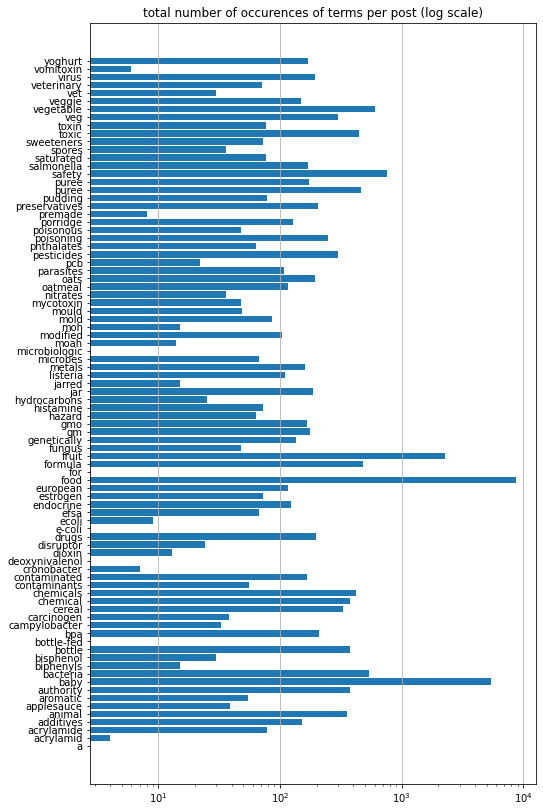

In [29]:
temp_items = list(zip(*sorted(total_results.items())))

plt.figure(figsize=(8,14))
plt.xscale('log')
plt.grid(axis='x')
plt.barh(temp_items[0], temp_items[1])
plt.title('total number of occurences of terms per post (log scale)')

Text(0.5, 1.0, 'total number of occurences of terms per post')

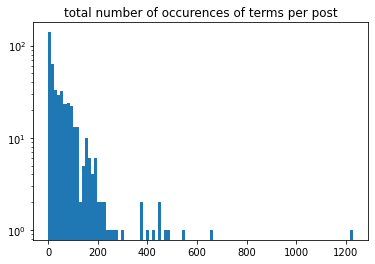

In [30]:
plt.hist(tf_per_doc, bins=100)
plt.yscale('log')
plt.title('total number of occurences of terms per post')

## Netmums

In [31]:
textdict = {key: value['title'] + ' ' + \
	' '.join([str(item['body']) for item in value['posts']]) for key, value in netmums.items()}

urltextdict = {key: ' '.join([' '.join([subitem for subitem in item['body_urls']]) for item in value['posts']]) for key, value in netmums.items()}

In [32]:
nm_spars, term_counter = get_counts_from_text_dict(textdict)

In [33]:
#examine result
term_counter.vocabulary_ #dict of index numbers for different features

total_term_frequency = np.sum(nm_spars.toarray(), axis=0)
tf_per_doc = np.sum(nm_spars.toarray(), axis=1)


total_results = {key: total_term_frequency[value] for key, value in term_counter.vocabulary_.items()}
total_per_doc = {key: tf_per_doc[num] for num, key in enumerate(textdict.keys())}


total_term_frequency

array([    0,     0,     3,   596,  1249,    15,     6,   151, 48485,
        2165,     6,    17, 14642,     0,   324,    31,    23,  2508,
         947,  1205,    11,   177,    11,     0,    10,     5,   984,
           0,    29,    10,    40,    16,   111, 35618,     0, 10351,
       15617,    70,    54,    67,    29,   370,   217,     1,  1641,
         157,   332,    44,    15,     0,     0,    77,    16,   131,
        1058,     1,    20,   108,  1031,    84,    14,   137,     9,
         864,   105,  2614,    76,   420,  1894,  1483,   328,   924,
         319,   191,   110,   559,   663,    49,  8613,   617,  1304,
         782,    46,  1150,     0,  2700])

In [34]:
tf_per_doc

array([68,  4, 28, ...,  2,  8,  4])

Text(0.5, 1.0, 'total number of occurences of terms per post (log scale)')

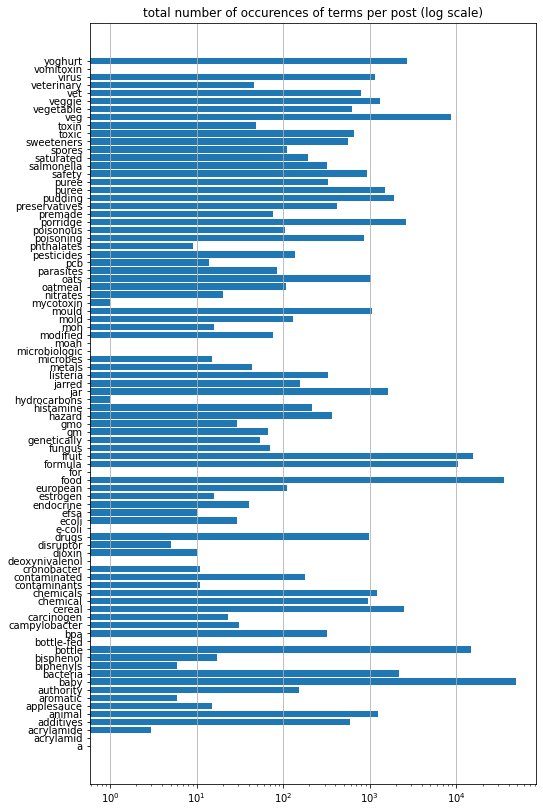

In [35]:
temp_items = list(zip(*sorted(total_results.items())))

plt.figure(figsize=(8,14))
plt.xscale('log')
plt.grid(axis='x')
plt.barh(temp_items[0], temp_items[1])
plt.title('total number of occurences of terms per post (log scale)')

In [36]:
#URL stuff

nmurl_spars, urlterm_counter = get_counts_from_text_dict(urltextdict)

#examine result
urlterm_counter.vocabulary_ #dict of index numbers for different features

total_term_frequency = np.sum(nmurl_spars.toarray(), axis=0)
tf_per_doc = np.sum(nmurl_spars.toarray(), axis=1)


total_results = {key: total_term_frequency[value] for key, value in urlterm_counter.vocabulary_.items()}
total_per_doc = {key: tf_per_doc[num] for num, key in enumerate(urltextdict.keys())}


total_term_frequency

array([   0,    0,    0,    5,    8,    1,    0,    2, 4543,    3,    0,
          1,  107,    0,    9,    0,    0,    8,    6,    3,    1,    2,
          3,    0,    1,    0,   13,    0,    0,    6,    0,    0,    1,
       2572,    0,  139,   28,    0,    0,    2,   12,    1,    1,    0,
          7,    0,    2,    1,    0,    0,    0,    0,    0,    2,    9,
          0,    1,    1,    1,    1,    2,    1,    0,    6,    0,    2,
          0,    0,   10,    0,    0,   61,    4,    0,    0,    7,    9,
          0,    7,    8,    7,    0,    1,    1,    0,   12])

Text(0.5, 1.0, 'total number of occurences of terms per post (log scale)')

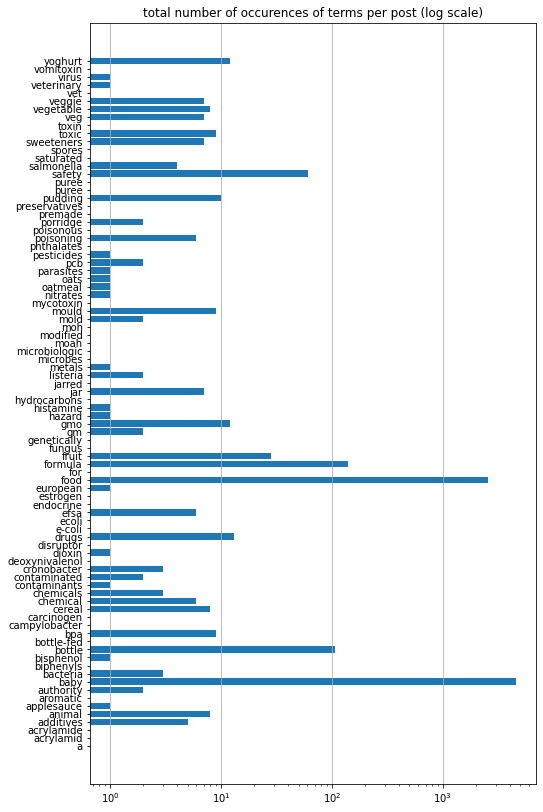

In [37]:
temp_items = list(zip(*sorted(total_results.items())))

plt.figure(figsize=(8,14))
plt.xscale('log')
plt.grid(axis='x')
plt.barh(temp_items[0], temp_items[1])
plt.title('total number of occurences of terms per post (log scale)')

In [40]:
[key for key, item in total_per_doc.items() if item > 1]

['https://www.netmums.com/coffeehouse/being-mum-794/babies-birth-12-months-58/890685-calpol-side-effects.html',
 'https://www.netmums.com/coffeehouse/family-food-recipes-555/food-tips-ideas-556/840648-healthy-non-processed-cheap-foodie-thread.html',
 'https://www.netmums.com/coffeehouse/being-mum-794/children-4-11-years-60/1857707-water-bottle-school-doesnt-leak.html',
 'https://www.netmums.com/coffeehouse/being-mum-794/babies-birth-12-months-58/1002308-13-weeks-old-baby-still-unsettled.html',
 'https://www.netmums.com/coffeehouse/drop-clinic-984/baby-child-health-989/642588-constipated-5-week-old-baby.html',
 'https://www.netmums.com/coffeehouse/drop-clinic-984/baby-child-health-989/947811-hv-advised-i-put-nesquick-babys-milk.html',
 'https://www.netmums.com/coffeehouse/being-mum-794/babies-birth-12-months-58/1110269-constipation.html',
 'https://www.netmums.com/coffeehouse/drop-clinic-984/weaning-560/900335-ellas-kitchen-pouches-good-bad.html',
 'https://www.netmums.com/coffeehouse/d

# Create Dataframes

In [74]:
from pprint import pprint


In [437]:
pprint(netmums[nmkeys[0]])

{'posts': [{'body': "Hi all, I've been giving my LO Aptamil Hungry Baby as she "
                    "is always starving! \xa0Since I started her on it she's "
                    "she's had a runny tummy - has Hungry Baby had this affect "
                    "on any one else's LO? \n"
                    " I hope it isn't the way I'm making the formula - I boil "
                    'the water and put it in the bottles and then put them in '
                    'the fridge and then add formula when she starts yelling '
                    "for food and warm it up. \xa0Can't see how you would "
                    'anticipate half an hour before your baby is hungry so you '
                    'can make it up like they say on the packet!?? \n'
                    ' Thinking of making up formula like they say and then '
                    "putting it in the fridge ready for when she's hungry - "
                    'saw that some other mums do it that way on another '
                

                    'has had her second one i will give it about a hour and '
                    'make 2 more.all my mates use to make a days worth in the '
                    'morning so they would make about 6 ish and there baby '
                    'would drink them thu out the day and they are all ok,leah '
                    'was crying alot when she was about 6/8 weeks old and i '
                    'thought that was cos she was hungry when i asked h/v bout '
                    'putting her on hungry milk she said no as it can upset '
                    'her tummy so i have stuck with the blue and give leah a '
                    'extra bottle if she needs it \xa0xx',
            'body_urls': [],
            'date': '8/20/2008 at 9:08 PM',
            'likes': '0',
            'quotes_w': [],
            'quotes_y': [],
            'username': 'Anonymous'},
           {'body': "I too thought it was common knowledge that you're not to "
                    'give babies bot